In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,  AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb
import shap
from catboost import CatBoostClassifier


# Intro  
This is solution for Kaggle compitition (Spaceship Titianic)[https://www.kaggle.com/competitions/spaceship-titanic/overview]  
It is binary classification with known labels.  
  
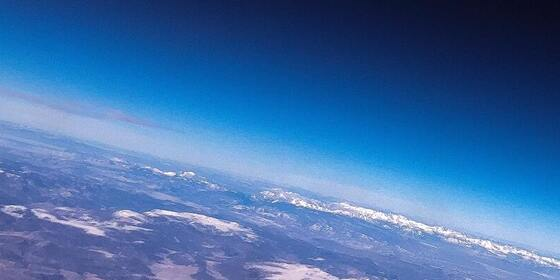  

## Description of the Set up  
Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.  

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.  

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!  

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.  

## About the metrics  
**Classification accuracy** is the metric on which the competition on Kaggle is being graded.

# Spaceship Titanic

## Data Description  
PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.  
HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.  
CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.  
Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.  
Destination - The planet the passenger will be debarking to.  
Age - The age of the passenger.  
VIP - Whether the passenger has paid for special VIP service during the voyage.  
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.  
Name - The first and last names of the passenger.  
Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.  

## EDA  
Processing and results are discussed in the end of this section.

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

display(train_df.head())
print(train_df.info())

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None


In [3]:
print("Number of duplicate rows in train set:", train_df.duplicated().sum())


Number of duplicate rows in train set: 0


In [4]:
# passanger id has form of gggg_pp, where gggg is group, and pp is number of people in it
# we can extract this information into two columns

train_df['Group'] = train_df['PassengerId'].astype(str).str[:-3].astype(int)
train_df['GroupSize'] = train_df['PassengerId'].astype(str).str[-2:].astype(int)

train_df['GroupSize'] = train_df.groupby('Group')['GroupSize'].transform('max')
display(train_df.head())

train_df.drop(['PassengerId', 'Group'], inplace=True, axis=1)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,GroupSize
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,1


,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,224.687617,458.077203,173.729169,311.138778,304.854791
std,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,76.000000,27.000000,59.000000,46.000000
max,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RoomService   8512 non-null   float64
 1   FoodCourt     8510 non-null   float64
 2   ShoppingMall  8485 non-null   float64
 3   Spa           8510 non-null   float64
 4   VRDeck        8505 non-null   float64
dtypes: float64(5)
memory usage: 339.7 KB
None


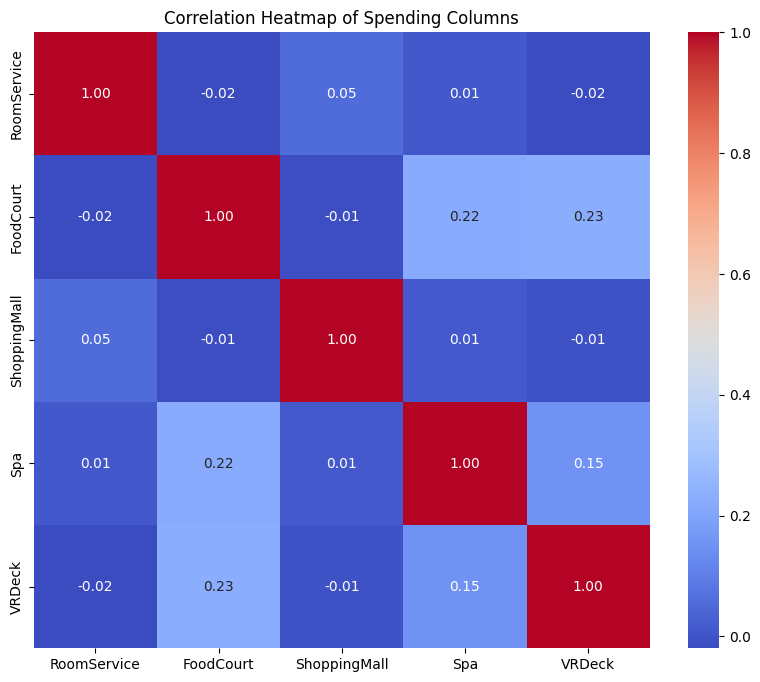

In [ ]:
# Let's check spending columns
spending_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
spending_dataset = train_df[spending_columns].copy()

display(spending_dataset.describe())
print(spending_dataset.info())

plt.figure(figsize=(10, 8))
sns.heatmap(spending_dataset.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Spending Columns')
plt.show()


In [6]:
# correlation is small
train_df[spending_columns] = train_df[spending_columns].fillna(0)
train_df['total_spending'] = train_df[spending_columns].sum(axis=1)
spending_columns.append('total_spending')

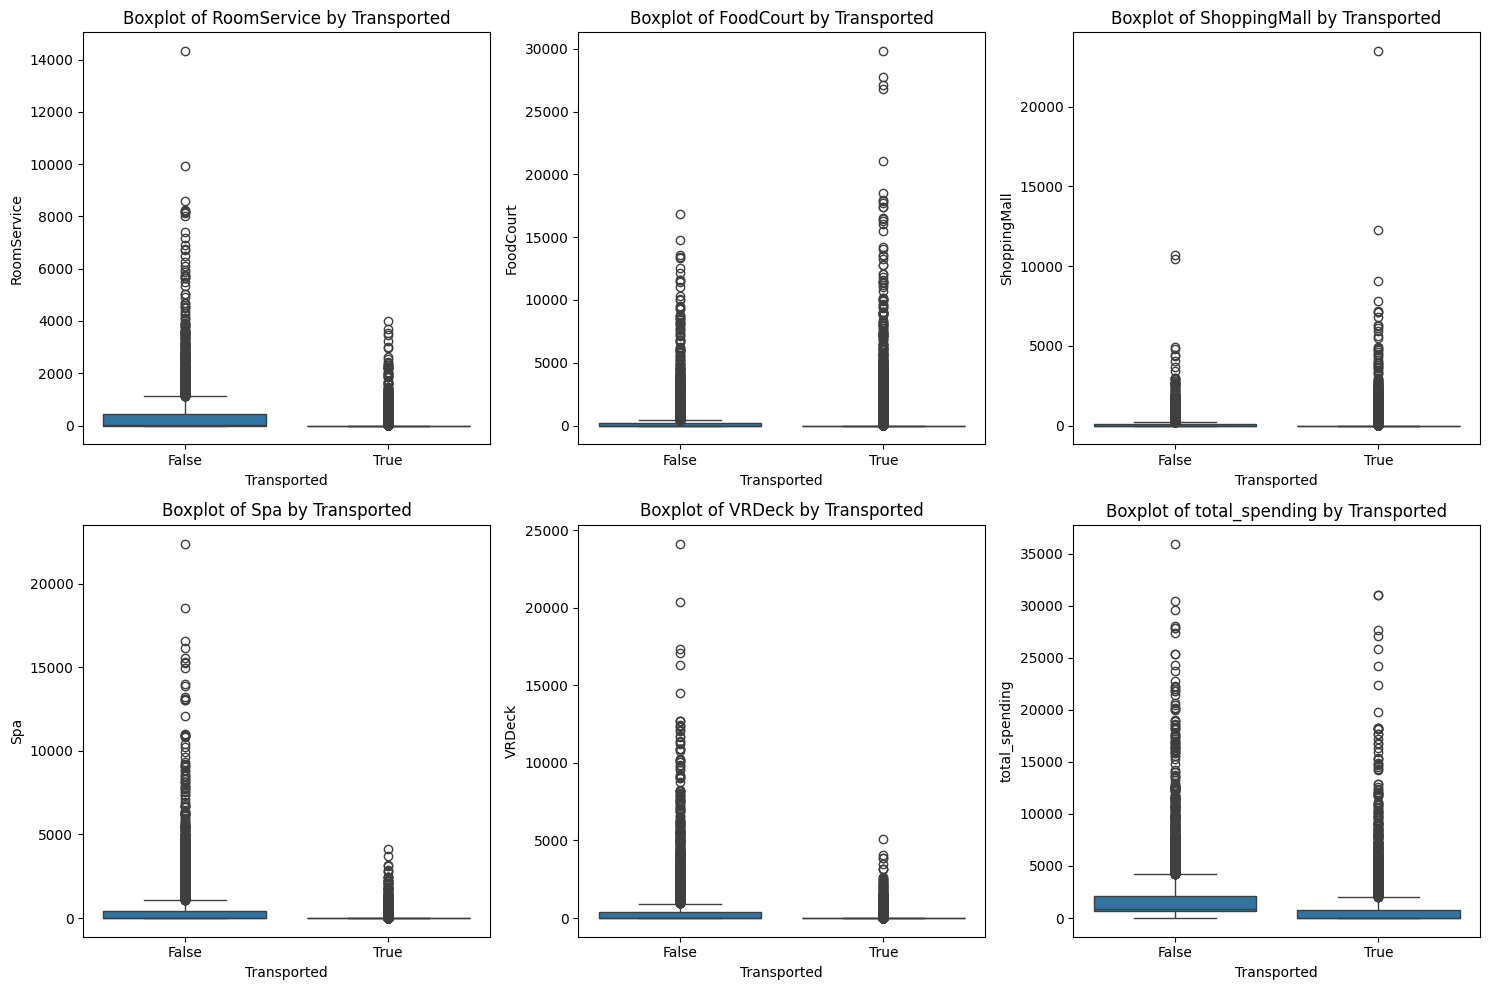

['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [7]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(spending_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Transported', y=col, data=train_df)
    plt.title(f'Boxplot of {col} by Transported')
    plt.xlabel('Transported')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

spending_columns.remove('total_spending')
spending_columns

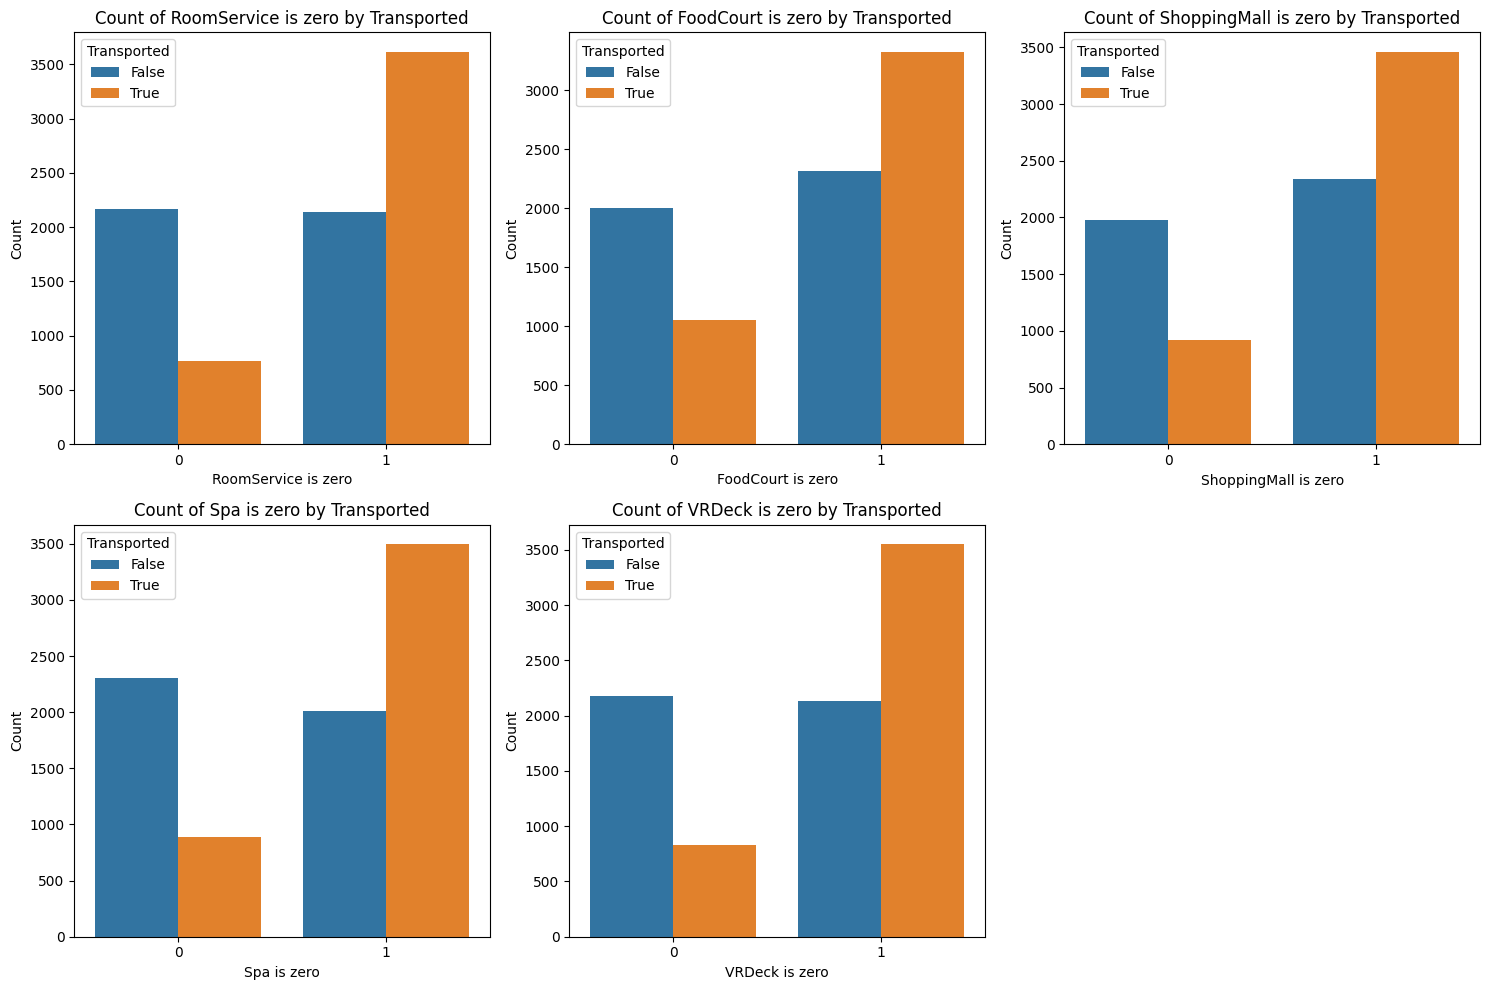

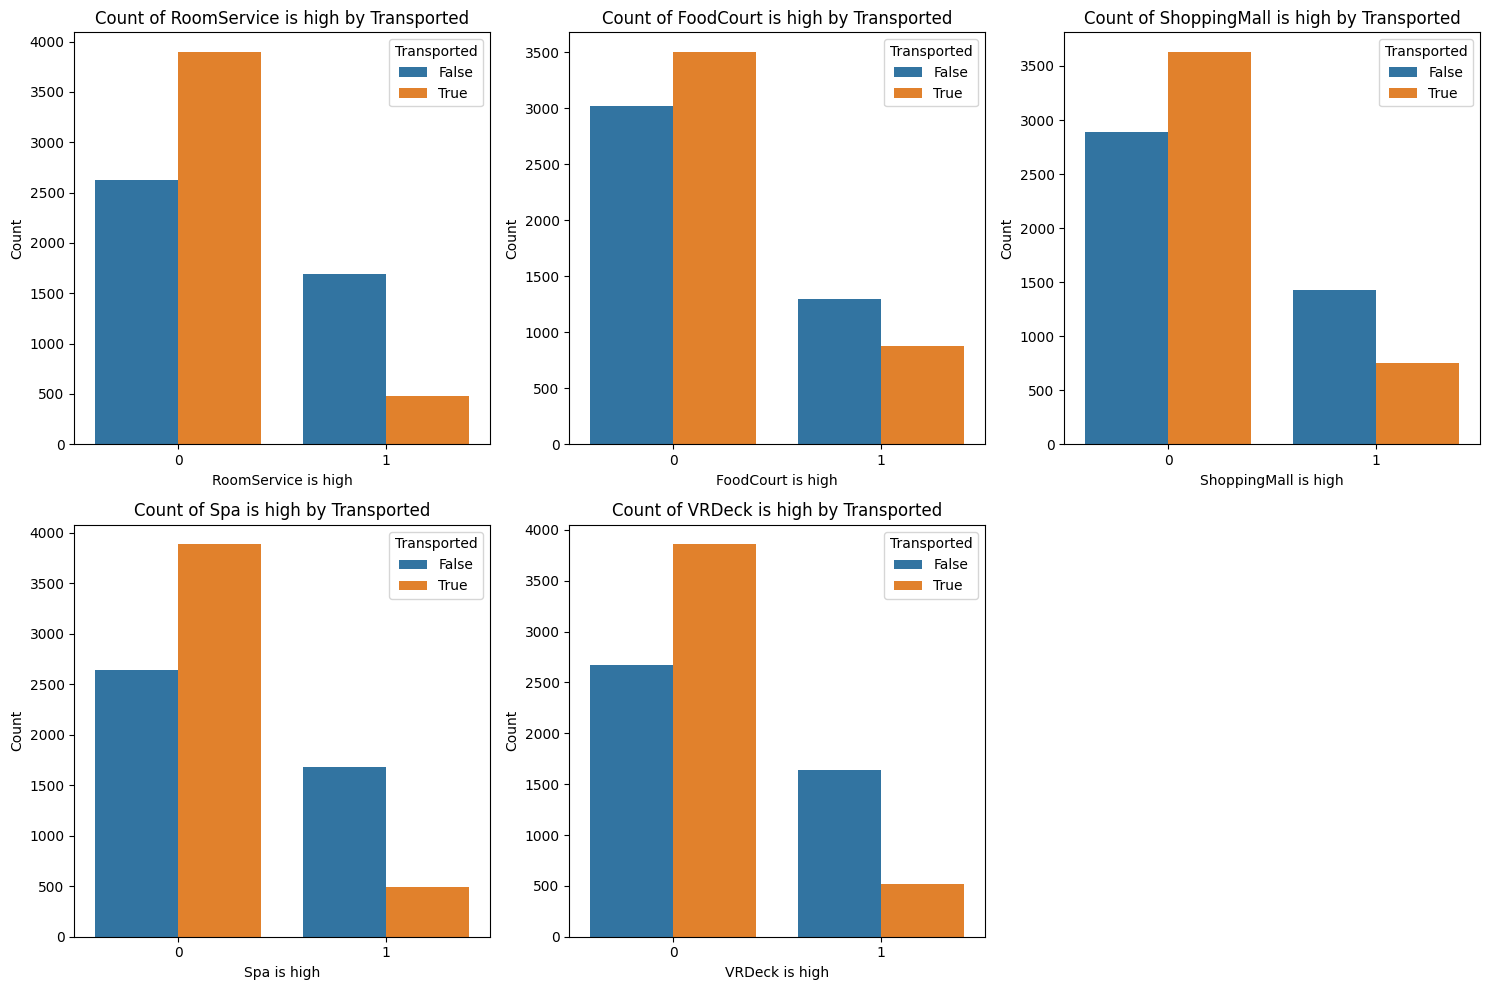

In [ ]:
list_of_cols_to_drop = []
for col in spending_columns:
    train_df[f'{col}_is_zero'] = (train_df[col] == 0).astype(int)
    q3 = train_df[col].quantile(0.75)
    train_df[f'{col}_is_high'] = (train_df[col] > q3).astype(int)
    list_of_cols_to_drop.append(f'{col}_is_zero')
    list_of_cols_to_drop.append(f'{col}_is_high')
    

plt.figure(figsize=(15, 10))
for i, col in enumerate(spending_columns, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=f'{col}_is_zero', hue='Transported', data=train_df)
    plt.title(f'Count of {col} is zero by Transported')
    plt.xlabel(f'{col} is zero')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()


plt.figure(figsize=(15, 10))
for i, col in enumerate(spending_columns, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=f'{col}_is_high', hue='Transported', data=train_df)
    plt.title(f'Count of {col} is high by Transported')
    plt.xlabel(f'{col} is high')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

train_df.drop(list_of_cols_to_drop, inplace=True, axis=1)


In [9]:
train_df.drop('total_spending', axis=1, inplace=True)

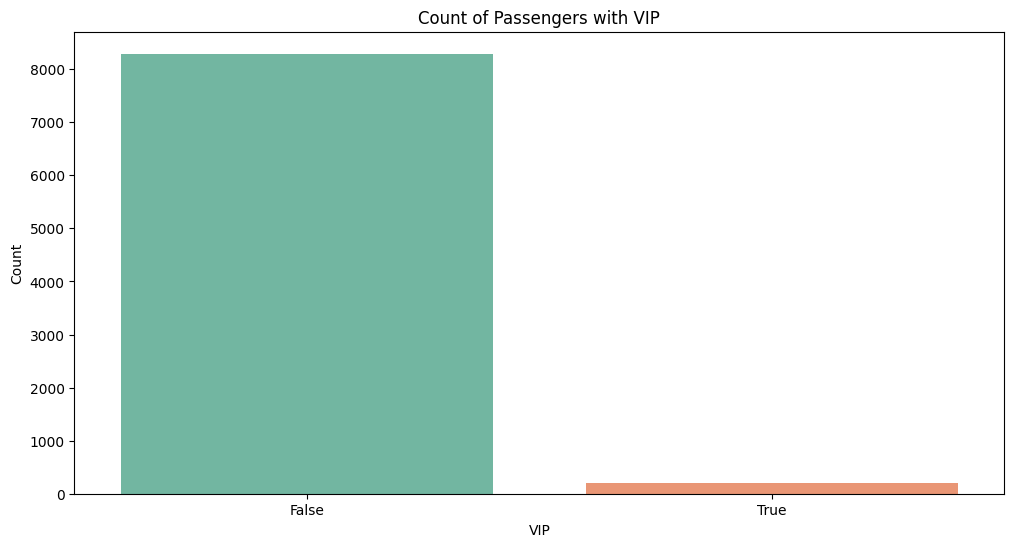

In [10]:
plt.figure(figsize=(12, 6))
sns.countplot(x='VIP', data=train_df, palette='Set2')
plt.title('Count of Passengers with VIP')
plt.xlabel('VIP')
plt.ylabel('Count')
plt.show()

train_df['VIP'].fillna(False, inplace=True)

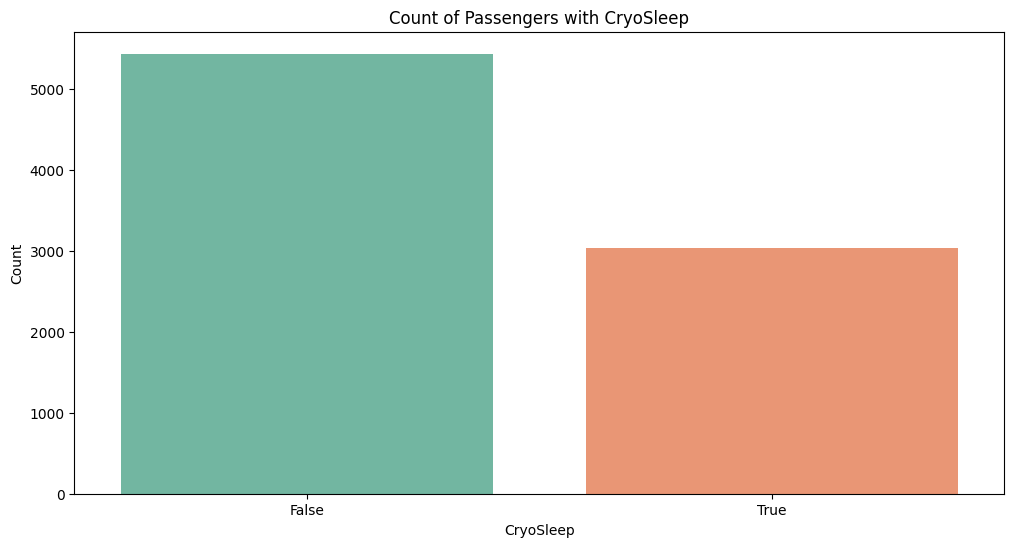

Number of missing values in CryoSleep column: 217


In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(x='CryoSleep', data=train_df, palette='Set2')
plt.title('Count of Passengers with CryoSleep')
plt.xlabel('CryoSleep')
plt.ylabel('Count')
plt.show()

print("Number of missing values in CryoSleep column:", train_df['CryoSleep'].isnull().sum())
train_df['CryoSleep'].fillna(False, inplace=True)


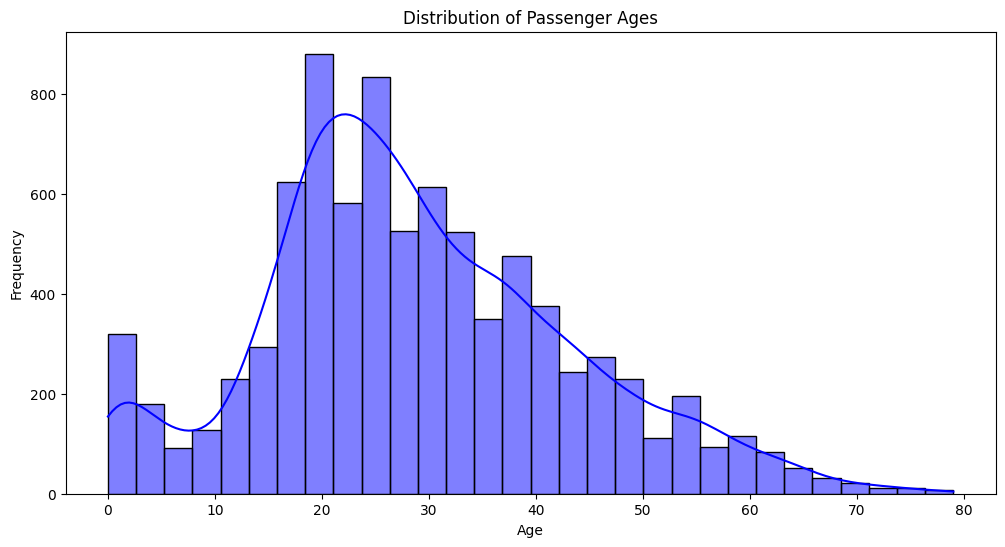

Number of missing values in Age column: 179


In [12]:
# distirbution of age
plt.figure(figsize=(12, 6))
sns.histplot(train_df['Age'], bins=30, kde=True, color='blue')
plt.title('Distribution of Passenger Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

print(f'Number of missing values in Age column: {train_df["Age"].isnull().sum()}')

train_df['Age'].fillna(train_df['Age'].mean(), inplace=True)

In [13]:
train_df['LastName'] = train_df['Name'].str.split(' ').str[-1]
test_df['LastName'] = test_df['Name'].str.split(' ').str[-1]

combined_df = pd.concat([train_df, test_df], axis=0)


def get_num_family(lastname):
    if lastname == '' or lastname == 'nan':
        return 0
    else:
        return combined_df[combined_df['LastName'] == lastname].shape[0]


train_df['Num_family'] = train_df['LastName'].apply(get_num_family)

test_df['Num_family'] = test_df['LastName'].apply(get_num_family)

print(train_df[['Name', 'LastName', 'Num_family']].sort_values(by='Num_family', ascending=False).head(50))

train_df.drop(['Name', 'LastName'], axis=1, inplace=True)

                    Name     LastName  Num_family
4948     Jerek Buckentry    Buckentry          19
7175       Moniey Belley       Belley          19
7622       Stenny Belley       Belley          19
5062      Leen Buckentry    Buckentry          19
5066     Becca Buckentry    Buckentry          19
5065    Eduana Buckentry    Buckentry          19
8058    Jarena Buckentry    Buckentry          19
4417     Fayey Buckentry    Buckentry          19
6046       Monald Belley       Belley          19
8057      Kris Buckentry    Buckentry          19
2740       Allene Belley       Belley          19
5064    Chelsa Buckentry    Buckentry          19
3750        Luisy Belley       Belley          19
7313       Briane Belley       Belley          19
7314        Gordo Belley       Belley          19
7315       Willah Belley       Belley          19
7316       Eddiey Belley       Belley          19
2205       Teryla Belley       Belley          19
2206       Megany Belley       Belley          19


In [14]:
train_df['Destination'].fillna('Unknown', inplace=True)
train_df['HomePlanet'].fillna('Unknown', inplace=True)

print(train_df['Destination'].value_counts())
print(train_df['HomePlanet'].value_counts())

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Unknown           182
Name: count, dtype: int64
HomePlanet
Earth      4602
Europa     2131
Mars       1759
Unknown     201
Name: count, dtype: int64


In [15]:
train_df = pd.get_dummies(train_df, columns=['Destination', 'HomePlanet'], drop_first=True)
train_df.head()

,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupSize,Num_family,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_Unknown,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Unknown
0,False,B/0/P,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,3,False,True,False,True,False,False
1,False,F/0/S,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,4,False,True,False,False,False,False
2,False,A/0/S,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,2,7,False,True,False,True,False,False
3,False,A/0/S,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2,7,False,True,False,True,False,False
4,False,F/1/S,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,9,False,True,False,False,False,False


In [ ]:
# parsing of the cbun number (when possible) to gain deck/num/side information (3 columns) instead of one

def parse_cabin(cabin):
    if pd.isnull(cabin) or cabin == '':
        return ['U', '-100', 'U']
    else:
        cabin = cabin.split('/')
        return [cabin[0], cabin[1], cabin[2]]
    
train_df['Deck'] = train_df['Cabin'].apply(lambda x: parse_cabin(x)[0])
train_df['Room'] = train_df['Cabin'].apply(lambda x: parse_cabin(x)[1]).astype(int)

train_df['Room'] = train_df['Room'].replace(-100, train_df['Room'].mean())
train_df['Side'] = train_df['Cabin'].apply(lambda x: parse_cabin(x)[2])

print(train_df['Deck'].value_counts())
print(train_df['Side'].value_counts())

train_df = pd.get_dummies(train_df, columns=['Deck', 'Side'], drop_first=True)

train_df.drop('Cabin', axis=1, inplace=True)


Deck
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
U     199
T       5
Name: count, dtype: int64
Side
S    4288
P    4206
U     199
Name: count, dtype: int64


In [17]:
display(train_df.head())
print(train_df.info())

columns_to_scale = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Age', 'GroupSize', 'Num_family']
sclarer = StandardScaler()
train_df[columns_to_scale] = sclarer.fit_transform(train_df[columns_to_scale])

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupSize,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Side_S,Side_U
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,...,True,False,False,False,False,False,False,False,False,False
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,...,False,False,False,False,True,False,False,False,True,False
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,2,...,False,False,False,False,False,False,False,False,True,False
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2,...,False,False,False,False,False,False,False,False,True,False
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,...,False,False,False,False,True,False,False,False,True,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8693 non-null   bool   
 1   Age                        8693 non-null   float64
 2   VIP                        8693 non-null   bool   
 3   RoomService                8693 non-null   float64
 4   FoodCourt                  8693 non-null   float64
 5   ShoppingMall               8693 non-null   float64
 6   Spa                        8693 non-null   float64
 7   VRDeck                     8693 non-null   float64
 8   Transported                8693 non-null   bool   
 9   GroupSize                  8693 non-null   int64  
 10  Num_family                 8693 non-null   int64  
 11  Destination_PSO J318.5-22  8693 non-null   bool   
 12  Destination_TRAPPIST-1e    8693 non-null   bool   
 13  Destination_Unknown        8693 non-null   bool 

## Discussion of EDA  
During the dataset processing those steps were performed and observations made:  
1) There are no duplicates in the dataframe.  
2) Column passangerId can be used to extract information on the group size in which the passanger travels and immited.  
3) For boolean columns traveling VIP and Cyrosleep False value were used to fill absent rows. It was attempted to find any correlation between cryosleep and other parameters, however, no clear correlation was found which might have helped to fill missing values.  
4) There are no outliers in the Age feature, missing values were replaced with mean.  
5) Speding columns are highly grouped around 0, yet it was not possible to use boolean 0 - not 0 spending as predictor. There are outliers there presented, however it was decided not to perform any operatons on them due to the huge number of ouliers. The columns were scalled with Standart Scaler.  
6) Cain information were used to extract deck and side of the sheep features.  
7) For categorical varibles missing valeus were filled with unknowh.  
8) All the categorical features were encoded with Dummy Encoder.

## Test df preprocessing  
In this section all the transformation found during work on train dataset were applied on the test data.

In [18]:

test_df['Group'] = test_df['PassengerId'].astype(str).str[:-3].astype(int)
test_df['GroupSize'] = test_df['PassengerId'].astype(str).str[-2:].astype(int)

test_df['GroupSize'] = test_df.groupby('Group')['GroupSize'].transform('max')

test_df.drop(['Group'], inplace=True, axis=1)


test_df['RoomService'].fillna(0, inplace=True)
test_df['FoodCourt'].fillna(0, inplace=True)
test_df['ShoppingMall'].fillna(0, inplace=True)
test_df['Spa'].fillna(0, inplace=True)
test_df['VRDeck'].fillna(0, inplace=True)


test_df['CryoSleep'].fillna(False, inplace=True)
test_df['VIP'].fillna(False, inplace=True)

test_df['Age'].fillna(test_df['Age'].mean(), inplace=True)

test_df.drop(['Name', 'LastName'], axis=1, inplace=True)

test_df['Destination'].fillna('Unknown', inplace=True)
test_df['HomePlanet'].fillna('Unknown', inplace=True)

test_df = pd.get_dummies(test_df, columns=['Destination', 'HomePlanet'], drop_first=True)

test_df['Deck'] = test_df['Cabin'].apply(lambda x: parse_cabin(x)[0])
test_df['Room'] = test_df['Cabin'].apply(lambda x: parse_cabin(x)[1]).astype(int)

test_df['Room'] = test_df['Room'].replace(-100, test_df['Room'].mean())
test_df['Side'] = test_df['Cabin'].apply(lambda x: parse_cabin(x)[2])

test_df.drop('Cabin', axis=1, inplace=True)

test_df = pd.get_dummies(test_df, columns=['Deck', 'Side'], drop_first=True)

display(test_df.head())
print(test_df.info())


test_df[columns_to_scale] = sclarer.transform(test_df[columns_to_scale])

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num_family,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Side_S,Side_U
0,0013_01,True,27.0,False,0.0,0.0,0.0,0.0,0.0,8,...,False,False,False,False,False,True,False,False,True,False
1,0018_01,False,19.0,False,0.0,9.0,0.0,2823.0,0.0,4,...,False,False,False,False,True,False,False,False,True,False
2,0019_01,True,31.0,False,0.0,0.0,0.0,0.0,0.0,6,...,False,True,False,False,False,False,False,False,True,False
3,0021_01,False,38.0,False,0.0,6652.0,0.0,181.0,585.0,2,...,False,True,False,False,False,False,False,False,True,False
4,0023_01,False,20.0,False,10.0,0.0,635.0,0.0,0.0,5,...,False,False,False,False,True,False,False,False,True,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                4277 non-null   object 
 1   CryoSleep                  4277 non-null   bool   
 2   Age                        4277 non-null   float64
 3   VIP                        4277 non-null   bool   
 4   RoomService                4277 non-null   float64
 5   FoodCourt                  4277 non-null   float64
 6   ShoppingMall               4277 non-null   float64
 7   Spa                        4277 non-null   float64
 8   VRDeck                     4277 non-null   float64
 9   Num_family                 4277 non-null   int64  
 10  GroupSize                  4277 non-null   int64  
 11  Destination_PSO J318.5-22  4277 non-null   bool   
 12  Destination_TRAPPIST-1e    4277 non-null   bool   
 13  Destination_Unknown        4277 non-null   bool 

In [19]:
#  check number of nan values
print(train_df.isnull().sum().sum())
print(test_df.isnull().sum().sum())

0
0


## ML part  
After the preprocessing several models with hyperparametrs were evaluated.  
Accuracy was used as the main score, as it is being used in the competition.  
A broad variety of models was tested (see the details below).

In [20]:
X_train = train_df.drop('Transported', axis=1)
y_train = train_df.Transported

In [ ]:
results = pd.DataFrame(columns=['model', 'best_params', 'best_score', 'mean_score', 'std_score', 'time', 'best_model'])

def perform_cross_validation(model_name, model, param_grid, X_train, y_train):
    print("Model: ", model_name, 'time:', time.strftime("%H:%M:%S", time.localtime()))
    start_time = time.time()

    # Perform grid search
    grid_search = GridSearchCV(model, param_grid, cv=5, verbose=0)
    grid_search.fit(X_train, y_train)
    
    # Print best parameters and best score
    print("Best Parameters: ", grid_search.best_params_)
    print("Best Score: ", grid_search.best_score_)
    
    # Perform cross-validation
    try:
        scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5)
        mean_score = scores.mean()
        std_score = scores.std()
    except Exception as e:
        print(f"Error during cross-validation for {model_name}: {e}")
    
    # Print cross-validation scores
    print("Cross-Validation Scores: ", scores)
    print("Mean Cross-Validation Score: ", scores.mean())
    total_time = time.time() - start_time

    # Dataframe with model
    global results
    results = pd.concat([results, pd.DataFrame([{
                                'model': model_name,
                                'best_params': grid_search.best_params_, 
                                'best_score': grid_search.best_score_, 
                                'mean_score': mean_score,
                                'std_score': std_score,
                                'time': total_time,
                                'best_model': grid_search.best_estimator_
                                }])], ignore_index=True)


    print("Finished model: ", model_name, 'time:', time.strftime("%H:%M:%S", time.localtime()), '\n')

# list of hyperparameters for GridSearchCV
tree_param_grid = {'max_depth': [None, 1, 2, 4, 6, 8, 10, 15, 20, 30]}

rf_param_grid = {'n_estimators': [None, 10, 50, 100, 200], 
                 'max_depth': [None, 1, 2, 5, 10, 15],
                 'bootstrap': [True, False]}

knn_param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 21],
                  'weights': ['uniform', 'distance'],
                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

logreg_param_grid = {'C': [0.01, 0.1, 1, 10],
                     'penalty': ['none', 'l2']}

svc_param_grid = {'C': [0.01, 0.1, 1, 10],
                'gamma': [0.01, 0.1, 1, 10]}

nb_param_grid = {}  # No additional parameters for Naive Bayes

xgb_param_grid = {'max_depth': [None, 1, 2, 5, 10, 16],
                  'learning_rate': [None, 0.01, 0.05, 0.1, 0.2],
                  'n_estimators': [None, 50, 100, 200, 300]}

lgb_param_grid = {'max_depth': [None, 1, 2, 5, 10, 16],
                    'learning_rate': [None, 0.01, 0.05, 0.1, 0.2],
                    'n_estimators': [None, 50, 100, 200, 300]} 

extra_trees_param_grid = {'n_estimators': [None, 10, 50, 100, 200, 300],
                          'max_depth': [None, 1, 2, 4, 6, 8, 10],
                          'bootstrap': [True, False]}

ada_boost_param_grid = {'n_estimators': [None, 10, 50, 100, 200, 300],
                       'learning_rate': [None, 0.01, 0.05, 0.1, 0.2]}

catboost_param_grid = {'depth': [None, 1, 2, 5, 10, 16],
                      'learning_rate': [None, 0.01, 0.05, 0.1, 0.2],
                      'iterations': [300]}


# list of models
models = [DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier(), LogisticRegression(), SVC()
        , GaussianNB(), xgb.XGBClassifier(silent=1)
        , lgb.LGBMClassifier(verbose=-1)
        , ExtraTreesClassifier()
        , AdaBoostClassifier()
        , CatBoostClassifier(verbose=False) 
        ]

list_of_names = ['DecisionTreeClassifier', 'RandomForestClassifier', 'KNeighborsClassifier', 'LogisticRegression'
        , 'SVC', 'GaussianNB', 'XGBClassifier', 'LGBMClassifier'
        , 'ExtraTreesClassifier'
        , 'AdaBoostClassifier'
        , 'CatBoostClassifier'
        ]

# list of hyperparameters
param_grids = [tree_param_grid, rf_param_grid, knn_param_grid, logreg_param_grid, svc_param_grid
            , nb_param_grid, xgb_param_grid, lgb_param_grid
            , extra_trees_param_grid, ada_boost_param_grid, catboost_param_grid]



In [22]:
%%time
# cross validation for each model
for name, model, param_grid in zip(list_of_names, models, param_grids):
    perform_cross_validation(name, model, param_grid, X_train, y_train)

Model:  DecisionTreeClassifier time: 15:31:40
Best Parameters:  {'max_depth': 4}
Best Score:  0.7564761833547182
Cross-Validation Scores:  [0.73490512 0.75848189 0.72857964 0.79056387 0.7698504 ]
Mean Cross-Validation Score:  0.7564761833547182
Finished model:  DecisionTreeClassifier time: 15:31:42 

Model:  RandomForestClassifier time: 15:31:42
Best Parameters:  {'bootstrap': True, 'max_depth': 10, 'n_estimators': 100}
Best Score:  0.796391323135196
Cross-Validation Scores:  [0.77515814 0.786659   0.79988499 0.81818182 0.79459148]
Mean Cross-Validation Score:  0.794895086061259
Finished model:  RandomForestClassifier time: 15:33:01 

Model:  KNeighborsClassifier time: 15:33:01
Best Parameters:  {'algorithm': 'ball_tree', 'n_neighbors': 1, 'weights': 'uniform'}
Best Score:  0.5619482249431078
Cross-Validation Scores:  [0.5986199  0.55089132 0.52041403 0.57249712 0.56731876]
Mean Cross-Validation Score:  0.5619482249431078
Finished model:  KNeighborsClassifier time: 15:33:09 

Model:  L

# Results Analysis  
Tree-based ensembly models performed the best.

In [ ]:
display(results.sort_values('best_score'
                            , ascending=False))

,model,best_params,best_score,mean_score,std_score,time,best_model
10,CatBoostClassifier,"{'depth': 10, 'iterations': 300, 'learning_rat...",0.801107,0.801107,0.012181,6386.424177,<catboost.core.CatBoostClassifier object at 0x...
6,XGBClassifier,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.797311,0.797311,0.017838,187.302005,"XGBClassifier(base_score=None, booster=None, c..."
7,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': 2, 'n_esti...",0.796392,0.796392,0.020959,228.736668,"LGBMClassifier(learning_rate=0.2, max_depth=2,..."
1,RandomForestClassifier,"{'bootstrap': True, 'max_depth': 10, 'n_estima...",0.796391,0.794895,0.014315,79.745155,"(DecisionTreeClassifier(max_depth=10, max_feat..."
8,ExtraTreesClassifier,"{'bootstrap': True, 'max_depth': None, 'n_esti...",0.793975,0.794896,0.020815,83.294517,"(ExtraTreeClassifier(random_state=849602266), ..."
3,LogisticRegression,"{'C': 10, 'penalty': 'l2'}",0.784079,0.784079,0.005221,0.827929,LogisticRegression(C=10)
9,AdaBoostClassifier,"{'learning_rate': 0.2, 'n_estimators': 300}",0.764756,0.764756,0.015299,52.833227,"(DecisionTreeClassifier(max_depth=1, random_st..."
0,DecisionTreeClassifier,{'max_depth': 4},0.756476,0.756476,0.022753,1.052927,DecisionTreeClassifier(max_depth=4)
5,GaussianNB,{},0.723228,0.723228,0.025611,0.040711,GaussianNB()
4,SVC,"{'C': 10, 'gamma': 0.01}",0.606697,0.606697,0.028204,170.907523,"SVC(C=10, gamma=0.01)"


In [24]:
total_time = results.time.sum()
print("Total time: ", total_time)
results.to_csv('results.csv', index=False)

Total time:  7198.911238193512


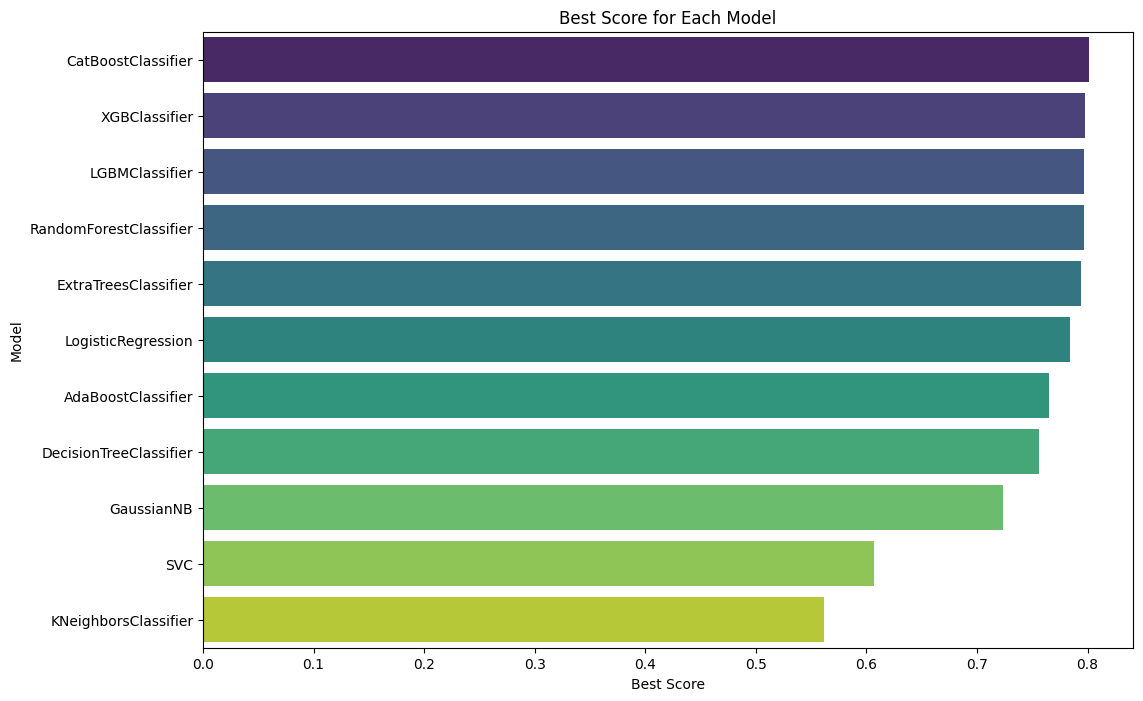

In [39]:
results = pd.read_csv('results.csv')
plt.figure(figsize=(12, 8))
sns.barplot(x='best_score', y='model', data=results.sort_values('best_score', ascending=False), palette='viridis')
plt.title('Best Score for Each Model')
plt.xlabel('Best Score')
plt.ylabel('Model')
plt.show()

In [25]:
passenger_id = test_df.PassengerId
test_df = test_df.drop('PassengerId', axis=1)

In [26]:
print(X_train.columns)
print(test_df.columns)
order_of_train_columns = X_train.columns.tolist()
test_df = test_df[order_of_train_columns]

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'GroupSize', 'Num_family', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'Destination_Unknown', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'HomePlanet_Unknown', 'Room', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U', 'Side_S',
       'Side_U'],
      dtype='object')
Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Num_family', 'GroupSize', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'Destination_Unknown', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'HomePlanet_Unknown', 'Room', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U', 'Side_S',
       'Side_U'],
      dtype='object')


In [27]:
order_of_train_columns = X_train.columns.tolist()
test_df = test_df[order_of_train_columns]

best_model = results.sort_values('best_score', ascending=False).iloc[0].best_model
predictions = best_model.predict(test_df)
submission = pd.DataFrame({'PassengerId': passenger_id, 'Transported': predictions.astype(bool)})

submission.to_csv('best_model_submission.csv', index=False)

In [28]:
try:
    best_model.fit(X_train, y_train)
    predictions = best_model.predict(test_df)
    submission = pd.DataFrame({'PassengerId': passenger_id, 'Transported': predictions.astype(bool)})
    submission.to_csv('best_model_submission_trained_on_whole_data.csv', index=False)
except Exception as e:
    print(f"Error during fitting the best model on the whole data: {e}")

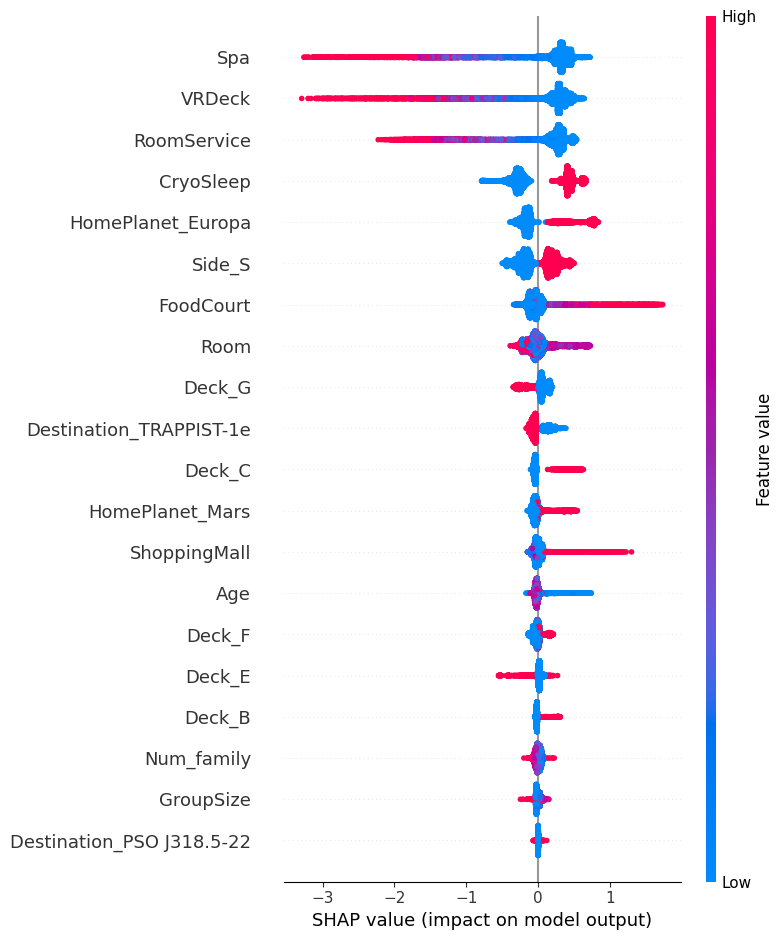

In [29]:
model = results.sort_values('best_score', ascending=False).iloc[0].best_model

feature_importance = model.feature_importances_

explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

plt.show()


## Alternative version with less features

In [34]:
%%time
try:
    X_train_less = X_train.drop(['Num_family', 'GroupSize', 'Deck_F', 'Deck_B', 'Deck_E', 'Deck_U', 'Side_U', 'Destination_PSO J318.5-22'], axis=1).copy()
except KeyError as e:
    X_train_less = X_train.copy()
    print(f"KeyError: {e}.")

results = pd.DataFrame(columns=['model', 'best_params', 'best_score', 'mean_score', 'std_score', 'time', 'best_model'])

perform_cross_validation(model_name='CatBoostLessFeatures'
                            , model=CatBoostClassifier(verbose=False)
                            , param_grid=catboost_param_grid
                            , X_train=X_train_less
                            , y_train=y_train)

Model:  CatBoostLessFeatures time: 17:39:48
Best Parameters:  {'depth': 5, 'iterations': 300, 'learning_rate': 0.01}
Best Score:  0.7971961188228357
Cross-Validation Scores:  [0.78320874 0.78895917 0.79355952 0.81875719 0.80149597]
Mean Cross-Validation Score:  0.7971961188228357
Finished model:  CatBoostLessFeatures time: 18:35:49 

CPU times: user 2h 16min 48s, sys: 1h 6min 7s, total: 3h 22min 55s
Wall time: 56min 1s


In [37]:
display(results.sort_values('best_score'
                            , ascending=False))

order_of_train_columns = X_train_less.columns.tolist()
test_df = test_df[order_of_train_columns]

best_model = results.sort_values('best_score', ascending=False).iloc[0].best_model
predictions = best_model.predict(test_df)
submission = pd.DataFrame({'PassengerId': passenger_id, 'Transported': predictions.astype(bool)})

submission.to_csv('best_model_submission_less_features.csv', index=False)
print("Submission saved to 'best_model_submission_less_features.csv'.")

,model,best_params,best_score,mean_score,std_score,time,best_model
0,CatBoostLessFeatures,"{'depth': 5, 'iterations': 300, 'learning_rate...",0.797196,0.797196,0.01233,3361.149049,<catboost.core.CatBoostClassifier object at 0x...


Submission saved to 'best_model_submission_less_features.csv'.


# Discussion  
Three-based models performed the best, especially Boosting models.  
Money-related features were the most important (Spa, VRDeck, RoomService).  
Also, CryoSleep was an important parameter, as well as Side of the ship.  
However, a tested model with reduced number of parameters did not perform well.  
The best accuracy obtained on test data on Kaggle was **0.80617** (0.82 is the best submission in the competition).  